In [70]:
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc

In [15]:
df = pd.read_csv('../data/Fake_Real_Data.csv')

In [16]:
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [17]:
df.groupby('label').size()

label
Fake    5000
Real    4900
dtype: int64

In [71]:
class_names = {'Real': 0, 'Fake': 1}
df['label'] = df['label'].map(class_names)

In [19]:
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,1
1,U.S. conservative leader optimistic of common ...,0
2,"Trump proposes U.S. tax overhaul, stirs concer...",0
3,Court Forces Ohio To Allow Millions Of Illega...,1
4,Democrats say Trump agrees to work on immigrat...,0


In [35]:
nlp = spacy.load('en_core_web_md') # if this fails then run "python -m spacy download en_core_web_md" to download that model

def textPrecessing(text):
    text = text.lower()
    
    doc = nlp(text)
    
    vectors = [
        token.vector 
        for token in doc 
        if not token.is_punct and not token.is_space and not token.is_stop
    ]
    
    if not vectors:
        return nlp.vocab.vectors.data.mean(axis=0) * 0
    
    return np.mean(vectors, axis=0)

Vector shape: (300,)


In [37]:
df['text_vector'] = df['Text'].apply(textPrecessing)

In [40]:
df.head()

,Text,label,text_vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,1,"[-0.6963317, 0.047695953, -0.0018420588, 0.029..."
1,U.S. conservative leader optimistic of common ...,0,"[-0.69835246, 0.040549494, 0.050829895, 0.0081..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",0,"[-0.7319601, 0.17264956, 0.13592821, -0.063043..."
3,Court Forces Ohio To Allow Millions Of Illega...,1,"[-0.68151456, 0.08318504, 0.1581444, -0.042669..."
4,Democrats say Trump agrees to work on immigrat...,0,"[-0.7106913, 0.06276051, 0.07968899, -0.003922..."


In [44]:
df['text_vector'].iloc[0].shape, df['text_vector'].shape

((300,), (9900,))

In [45]:
X = np.vstack(df['text_vector'].values)
y = df['label'].values

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,stratify=y)

In [54]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
X_train.shape

(7920, 300)

### Naive Bayes

In [77]:
def show_report(model, X_test, y_test):
    """
    Evaluates a classification model by printing the classification report 
    and plotting the Confusion Matrix and ROC Curve.
    
    Args:
        model: Trained classification model.
        X_test: Test features.
        y_test: True test labels.
        class_names: List of class labels (e.g., ['Negative', 'Positive']).
    """
    
    # --- Prediction Steps ---
    # Call predict_proba first, as it's often the prerequisite for both
    # the discrete predictions and the ROC curve.
    y_probs = model.predict_proba(X_test)
    y_pred = model.predict(X_test) 
    
    # --- 1. Classification Report ---
    print("--- CLASSIFICATION REPORT ---")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # --- 2. Confusion Matrix ---
    print("--- CONFUSION MATRIX ---")
    cm = confusion_matrix(y_test, y_pred)
    
    # Create the display object and plot it immediately
    plt.figure(figsize=(6, 6)) # Adjusted size slightly for better fit
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca()) 
    plt.title('Confusion Matrix')
    plt.show() 

    # --- 3. ROC Curve ---
    y_probs_positive = y_probs[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs_positive)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    
    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    # Labels and Title
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR) / Recall')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [56]:
mnb = MultinomialNB()

mnb.fit(X_train,y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


report for Multinomail Naive Bayes:
--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Real       0.91      0.88      0.90       980
        Fake       0.89      0.91      0.90      1000

    accuracy                           0.90      1980
   macro avg       0.90      0.90      0.90      1980
weighted avg       0.90      0.90      0.90      1980

--- CONFUSION MATRIX ---


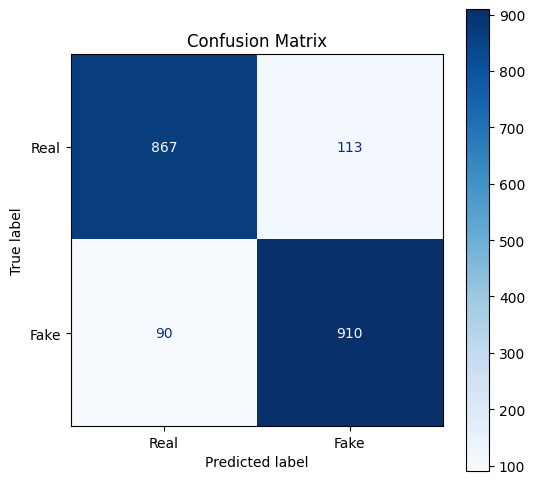

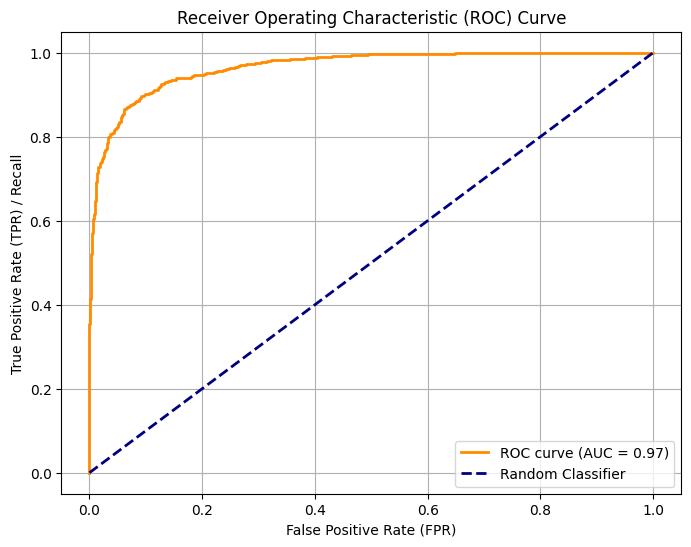

In [74]:
print("report for Multinomail Naive Bayes:")
show_report(mnb, X_test, y_test)

### Random Forest

In [61]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


report for Random Forest:
--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Real       0.96      0.97      0.96       980
        Fake       0.97      0.96      0.96      1000

    accuracy                           0.96      1980
   macro avg       0.96      0.96      0.96      1980
weighted avg       0.96      0.96      0.96      1980

--- CONFUSION MATRIX ---


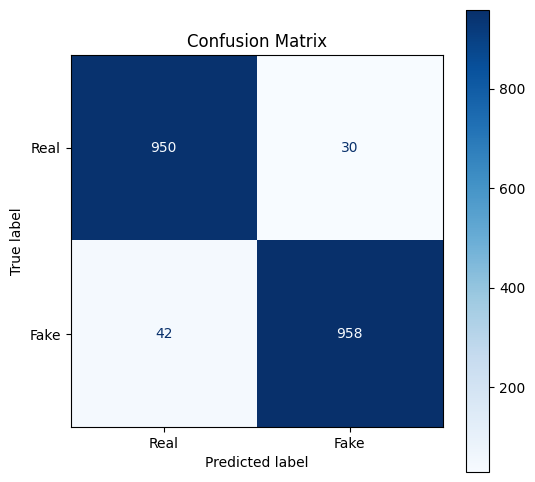

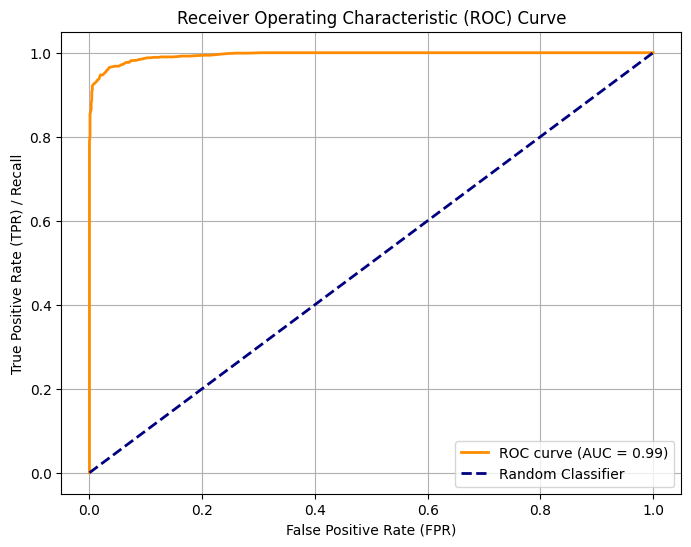

In [75]:
print("report for Random Forest:")
show_report(rf, X_test, y_test)

In [66]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


report GradientBoostingClassifier:
--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        Real       0.97      0.98      0.98       980
        Fake       0.98      0.97      0.98      1000

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980

--- CONFUSION MATRIX ---


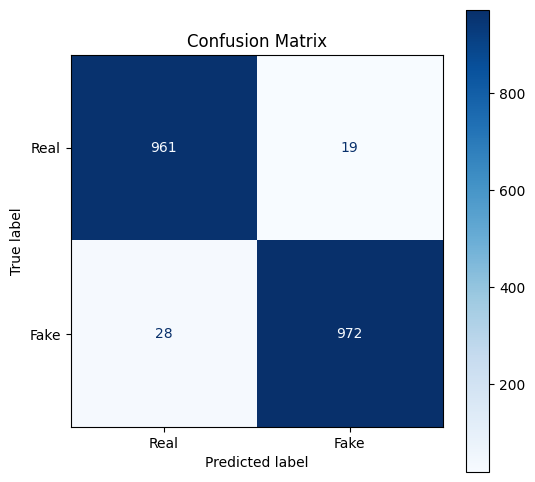

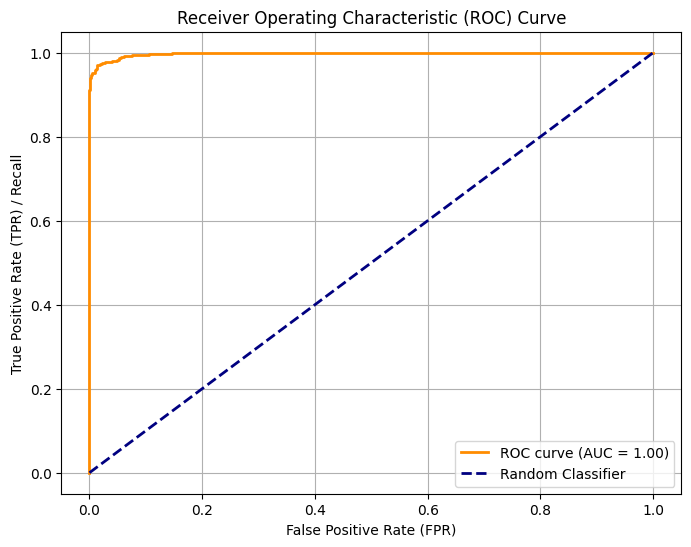

In [76]:
print("report GradientBoostingClassifier:")
show_report(gbc, X_test, y_test)

### So far the GradientBoostingClassifier has the highest recall, accurancy so far

In [78]:
# save the model
import joblib
joblib.dump(gbc, '../models/gradient_boosting_model.pkl')

['../models/gradient_boosting_model.pkl']